In [2]:
!uv pip install pandas altair matplotlib

Resolved 24 packages in 487ms                                        
Prepared 5 packages in 1.06s                                             
Installed 11 packages in 142ms                              
 + contourpy==1.3.1
 + cycler==0.12.1
 + fonttools==4.56.0
 + kiwisolver==1.4.8
 + matplotlib==3.10.1
 + numpy==2.2.4
 + pandas==2.2.3
 + pillow==11.1.0
 + pyparsing==3.2.3
 + pytz==2025.2
 + tzdata==2025.2


In [3]:
import glob
from datetime import date

import pandas as pd

import altair as alt

import matplotlib
import matplotlib.pyplot as plt

%matplotlib inline
matplotlib.rcParams['svg.fonttype'] = 'none'

In [26]:
ministry_mapping = {
    'BBk': 'BBank',
    'BK Amt': 'BK',
    'BMELV': 'BMEL',
    'BMELVV': 'BMEL',
    'BMVI': 'BMDV',
    'BMWi': 'BMWK',
    'BMVBS': 'BMDV',
    'BPräsA': 'BPrA',
    'BMJV': 'BMJ',
    'BMJVV': 'BMJ',
    'BMUB': 'BMUV',
    'BMU': 'BMUV'
}



def load_dataframe(filename):
    year = int(filename.split('_')[-1].split('.')[0])
    delimiter = "," if year < 2023 else ";"

    df = pd.read_csv(filename, delimiter=delimiter).fillna(0)
    df = df.rename(columns={'Ressort': 'name'})
    if "name" not in df.columns:
        df = df.rename(columns={df.columns[0]: 'name'})
    df = df[~df['name'].str.contains('Gesamt')]
    df['year'] = date(year, 1, 1)
    df['year'] = pd.to_datetime(df['year'])
    df['gb'] = df['name'].str.contains('GB')
    df['name'] = df['name'].str.replace(' GB', '')
    df['name'] = df['name'].str.replace(r'\*', '', regex=True).str.replace(r'\d', '', regex=True).str.strip()
    for k, v in ministry_mapping.items():
        df['name'] = df['name'].str.replace('^' + k + '$', v, regex=True)
    df = df.rename(columns={k: k.replace("Eingang Anträge", "Eingang Erstanträge") for k in df.columns if " in " in k})
    df = df.rename(columns={k: k.split(" in ")[0] for k in df.columns if " in " in k})
    df = df.rename(columns={k: k.strip().replace(' ', '_') for k in df.columns})
    
    if not 'sonstige_Erledigung' in df:
        print(filename)
        df['sonstige_Erledigung'] = 0
    
    return df

In [27]:
filenames = glob.glob('data/ifg_statistik_*.csv')

required_columns = ["name", "year", "Eingang_Erstanträge", "Eingang_Klagen", "Informationszugang_gewährt",
                    "Informationszugang_teilweise_gewährt", "Informationszugang_abgelehnt",
                   "sonstige_Erledigung", "Gebühr_erhoben", "Eingang_Widersprüche"]
all_columns = []
dfs = []
errors = []

for filename in filenames:
    # load file
    print(filename)
    df = load_dataframe(filename)
    dfs.append(df)
    
    # make sure our data isn't hot garbage
    columns = list(df.columns)
    for col in required_columns:
        if not col in columns:
            errors.append("{} missing in {}".format(col, df['year'][0].year))
    all_columns += columns

print('\n'.join(errors))
assert len(errors) == 0

df = pd.concat(dfs).filter(items=required_columns)
df.to_csv('ifg_statistik.csv', index=False)

data/ifg_statistik_2013.csv
data/ifg_statistik_2012.csv
data/ifg_statistik_2010.csv
data/ifg_statistik_2011.csv
data/ifg_statistik_2015.csv
data/ifg_statistik_2014.csv
data/ifg_statistik_2016.csv
data/ifg_statistik_2017.csv
data/ifg_statistik_2019.csv
data/ifg_statistik_2018.csv
data/ifg_statistik_2024.csv
data/ifg_statistik_2020.csv
data/ifg_statistik_2021.csv
data/ifg_statistik_2023.csv
data/ifg_statistik_2022.csv



In [28]:
df.tail()

,name,year,Eingang_Erstanträge,Eingang_Klagen,Informationszugang_gewährt,Informationszugang_teilweise_gewährt,Informationszugang_abgelehnt,sonstige_Erledigung,Gebühr_erhoben,Eingang_Widersprüche
52,BR,2022-01-01,13.0,0.0,6.0,0.0,0.0,8.0,0.0,0.0
53,BBank,2022-01-01,48.0,0.0,4.0,6.0,37.0,5.0,2.0,2.0
54,BVerfG,2022-01-01,46.0,0.0,15.0,14.0,13.0,3.0,1.0,1.0
55,BfDI,2022-01-01,139.0,2.0,56.0,3.0,10.0,55.0,1.0,2.0
56,BRH,2022-01-01,5.0,0.0,2.0,1.0,1.0,0.0,0.0,0.0


## Eingang Erstanträge über die Jahre

(0.0, 58928.1)

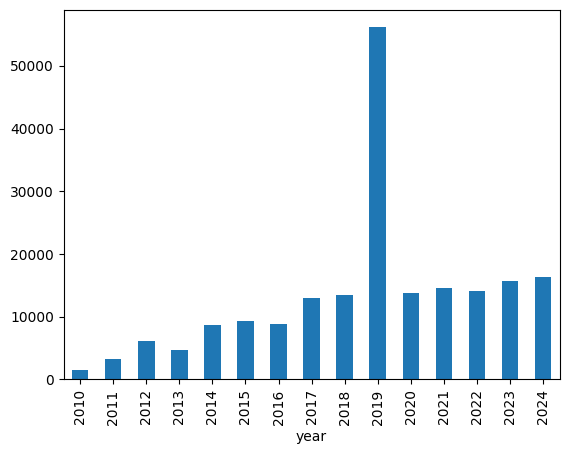

In [32]:
df.groupby(df['year'].dt.year)['Eingang_Erstanträge'].sum().plot(kind='bar')
plt.ylim(0)

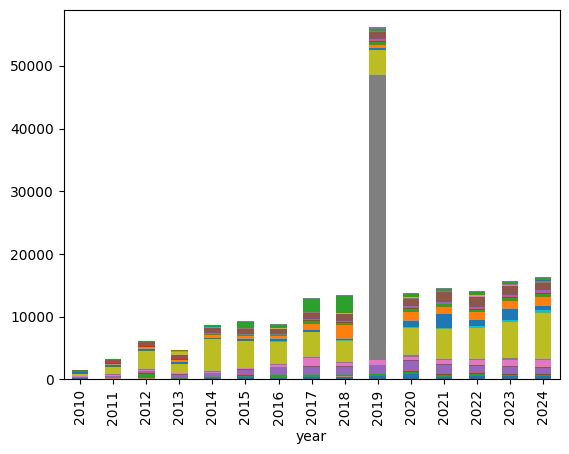

In [30]:
ax = df.groupby([df.year.dt.year, 'name'])['Eingang_Erstanträge'].sum().unstack().plot(kind='bar', stacked=True)
ax.legend().set_visible(False)

In [33]:
alt.Chart(df).mark_bar().encode(
    color='name',
    x='year',
    y='Eingang_Erstanträge',
    tooltip='name'
).interactive()

alt.Chart(...)

In [34]:
out_group = df.groupby(['name', 'year'])[required_columns].sum(numeric_only=True)
out_group['granted'] = out_group[['Informationszugang_gewährt', 'Informationszugang_teilweise_gewährt']].sum(1)
out_group['not_granted'] = out_group[['Informationszugang_abgelehnt', 'sonstige_Erledigung']].sum(1)
out_group['count'] = out_group['granted'] + out_group['not_granted']

out_group['transparency'] = out_group['granted'] / out_group['count'] * 100
out_group['transparency'] = out_group['transparency'].round()

out_group['filed_requests'] = out_group['Eingang_Erstanträge']
out_group['fees_charged'] = out_group['Gebühr_erhoben']
out_group['filed_objections'] = out_group['Eingang_Widersprüche']
out_group['filed_lawsuits'] = out_group['Eingang_Klagen']


out_group = out_group.reset_index()

out_cols = ['name', 'year', 'granted', 'not_granted', 'count', 'transparency', 'filed_requests',
           'fees_charged', 'filed_objections', 'filed_lawsuits']
out_group = out_group.filter(items=out_cols)
out_group['year'] = pd.to_datetime(out_group['year']).dt.year
out_group.to_csv('data.csv', index=False)